In [1]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 8.8 MB/s eta 0:00:00


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# === Cargar datos ===
DataMCI = pd.read_excel('/content/drive/MyDrive/datos-tesis/TorqueyPotenciavsRPM212cc.xls').values
DataME = pd.read_excel('/content/drive/MyDrive/datos-tesis/TorqyPotME3.5Kw.xls').values
DataBSFC = pd.read_excel('/content/drive/MyDrive/datos-tesis/BSFC212cc.xls').values
DataSEC = pd.read_excel('/content/drive/MyDrive/datos-tesis/SECmE3.5kw.xls').values
DataVelEPA = pd.read_excel('/content/drive/MyDrive/datos-tesis/VelEPA.xls').values

# === Preparar datos ===
rpmME = DataME[:, 0]
torqME = DataME[:, 1]

rpmMCI = DataMCI[:, 0]
torqMCI = DataMCI[:, 1]
powMCI = DataMCI[:, 2]

bsfc = DataBSFC[:, 1]
rpmSFC = DataBSFC[:, 0]

rpmSEC = DataSEC[:, 0]
sec = DataSEC[:, 1]

VelSET = 10 * DataVelEPA[:, 1] / max(DataVelEPA[:, 1])
VelSET_interp = interp1d(np.arange(len(VelSET)), VelSET, kind='linear')
VelSET = VelSET_interp(np.linspace(0, len(VelSET) - 1, 2 * 1370))

# === Funciones de torque, potencia, consumo ===
def TorqME(x): return -5.658e-11 * x**3 + 2.175e-07 * x**2 - 0.0001696 * x + 9.295
def TorqMCI(x): return -5.477e-10 * x**3 + 1.74e-06 * x**2 + 0.001801 * x + 7.088
def PotMCI(x): return -5.304e-10 * x**3 + 3.028e-06 * x**2 - 0.00315 * x + 2.154
def BSFC(x): return 2.771e-09 * x**3 + 2.363e-05 * x**2 - 0.1741 * x + 500.1
def SEC(x): return 7.418e-11 * x**3 - 3.658e-07 * x**2 + 0.0002685 * x + 11.66

# === Parámetros físicos ===
b = 0.5  # kg/m
m = 200
rt = 0.20
rd = 0.15
dt = 1
n = 1370

# === Modelo de velocidad ===
def vel(Vant, RPMc, RPMe, pMCI, pME):
    fuerza = pMCI * TorqMCI(RPMc) / rt + pME * TorqME(RPMe) / rd - b * Vant**2
    return Vant + (fuerza * dt / m)
# === Simulación sin lógica difusa (control básico con regla de error signo) ===
def simular_sin_difusa():
    VelAct = np.zeros(2 * n)
    consumo_comb = 0
    consumo_bat = 0
    Vant = 0
    RPMc = 0
    RPMe = 0
    pMCI = 0.5
    pME = 0.5

    for i in range(2 * n):
        if VelSET[i] < 0.2:
            VelAct[i] = 0
            Vant = 0
            pMCI = 0
            pME = 0
            RPMc = 0
            RPMe = 0
            continue

        VelAct[i] = vel(Vant, RPMc, RPMe, pMCI, pME)

        error = VelSET[i] - VelAct[i]
        if error > 0 and pMCI <= 0.9:
            pMCI += 0.1
        elif error < 0 and pMCI >= 0.1:
            pMCI -= 0.1

        # Mantener ambos motores activos al 50%, como referencia básica
        pME = 1 - pMCI  # Complementario para balance simple

        OmegaC = VelAct[i] / rt
        OmegaE = VelAct[i] / rd
        RPMc = 60 * OmegaC / (2 * np.pi)
        RPMe = 60 * OmegaE / (2 * np.pi)
        Vant = VelAct[i]

        consumo_comb += (pMCI * TorqMCI(RPMc) * OmegaC / 1000) * BSFC(RPMc) / 3600  # kg
        consumo_bat += (pME * TorqME(RPMe) * OmegaE / 1000) * SEC(RPMe) / 3600       # Wh

    return VelAct, consumo_comb, consumo_bat

# === Simulación con lógica difusa ===
def simular_con_difusa():
    VelAct = np.zeros(2 * n)
    consumo_comb = 0
    consumo_bat = 0
    Vant = 0
    RPMc = 0
    RPMe = 0
    pMCI = 0
    pME = 0
    prev_error = 0
    integral = 0
    alpha = 0.8
    prev_delta_error = 0

    error_f = ctrl.Antecedent(np.linspace(-2, 2, 7), 'error')
    delta_error_f = ctrl.Antecedent(np.linspace(-1, 1, 7), 'delta_error')
    modo_motor = ctrl.Consequent(np.arange(0, 3, 1), 'modo')
    names = ['NB', 'NM', 'Z', 'PM', 'PB']
    error_f.automf(names=names)
    delta_error_f.automf(names=names)
    modo_motor['MCI'] = fuzz.trimf(modo_motor.universe, [0, 0, 1])
    modo_motor['ME'] = fuzz.trimf(modo_motor.universe, [1, 2, 2])
    modo_motor['Ambos'] = fuzz.trimf(modo_motor.universe, [0.5, 1, 1.5])
    rules = [
        ctrl.Rule(error_f['NB'] | delta_error_f['NB'], modo_motor['MCI']),
        ctrl.Rule(error_f['NM'] | delta_error_f['NM'], modo_motor['MCI']),
        ctrl.Rule(error_f['Z'] & delta_error_f['Z'], modo_motor['Ambos']),
        ctrl.Rule(error_f['PM'] | delta_error_f['PM'], modo_motor['ME']),
        ctrl.Rule(error_f['PB'] | delta_error_f['PB'], modo_motor['ME']),
    ]
    sistema_ctrl = ctrl.ControlSystem(rules)
    sistema = ctrl.ControlSystemSimulation(sistema_ctrl)

    def pid(error, prev_error, integral, Kp=0.8, Ki=0.02, Kd=0.3):
        integral += error
        return Kp * error + Ki * integral + Kd * (error - prev_error), integral

    for i in range(2 * n):
        if VelSET[i] < 0.2:
            VelAct[i] = 0
            Vant = 0
            pMCI = 0
            pME = 0
            RPMc = 0
            RPMe = 0
            continue

        VelAct[i] = vel(Vant, RPMc, RPMe, pMCI, pME)
        error_val = VelSET[i] - VelAct[i]
        raw_delta_error = VelAct[i] - Vant
        delta_error_val = alpha * prev_delta_error + (1 - alpha) * raw_delta_error
        prev_delta_error = delta_error_val

        sistema.input['error'] = np.clip(error_val, -2, 2)
        sistema.input['delta_error'] = np.clip(delta_error_val, -1, 1)
        try:
            sistema.compute()
            modo = int(np.round(sistema.output['modo']))
        except:
            modo = 2

        control_signal, integral = pid(error_val, prev_error, integral)
        prev_error = error_val

        if modo == 0:
            pMCI = np.clip(control_signal, 0, 1)
            pME = 0
        elif modo == 1:
            pMCI = 0
            pME = np.clip(control_signal, 0, 1)
        else:
            pMCI = np.clip(control_signal / 2, 0, 1)
            pME = np.clip(control_signal / 2, 0, 1)

        OmegaC = VelAct[i] / rt
        OmegaE = VelAct[i] / rd
        RPMc = 60 * OmegaC / (2 * np.pi)
        RPMe = 60 * OmegaE / (2 * np.pi)
        Vant = VelAct[i]

        consumo_comb += (pMCI * TorqMCI(RPMc) * OmegaC / 1000) * BSFC(RPMc) / 3600
        consumo_bat += (pME * TorqME(RPMe) * OmegaE / 1000) * SEC(RPMe) / 3600

    return VelAct, consumo_comb, consumo_bat


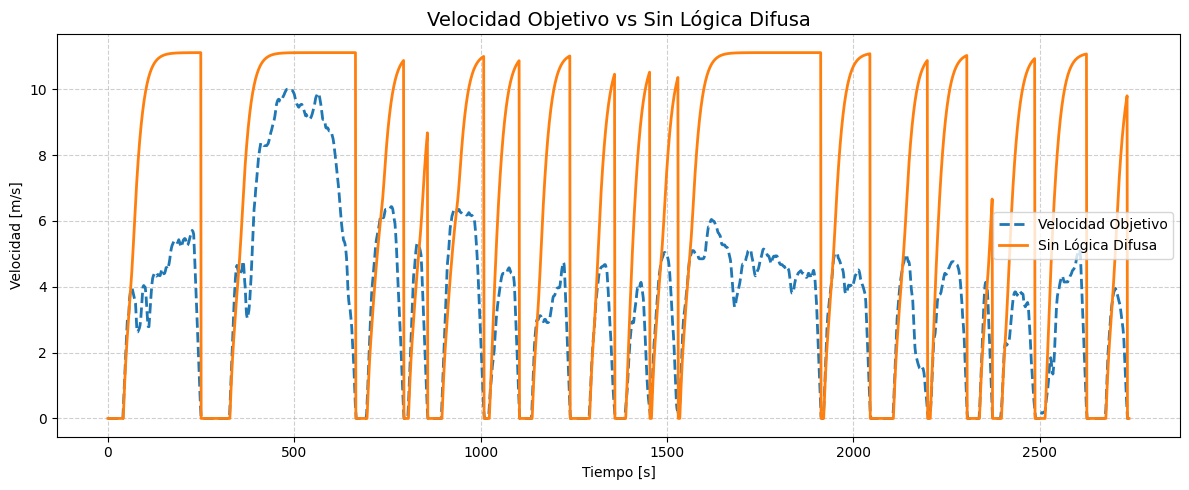

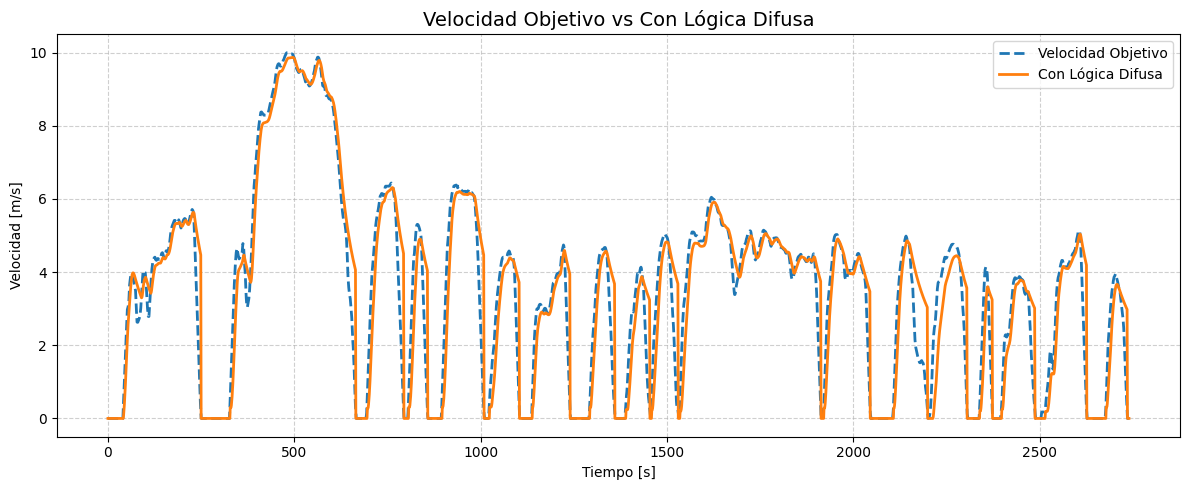

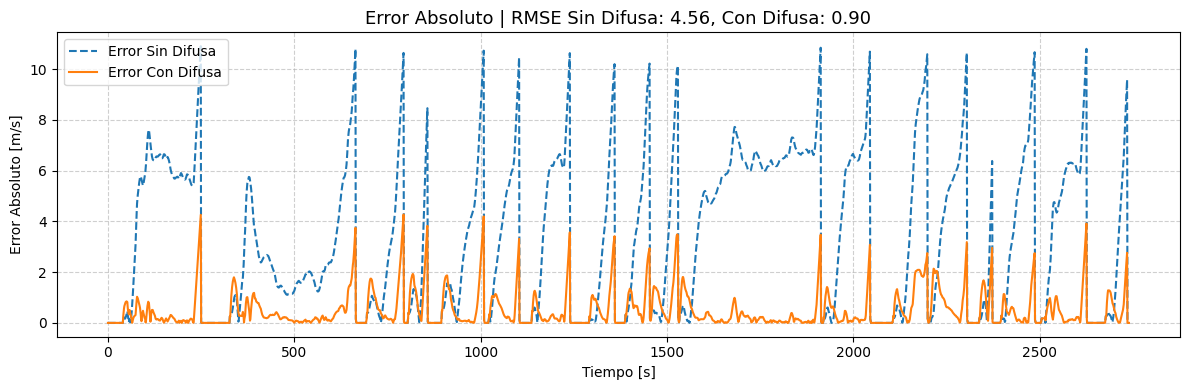

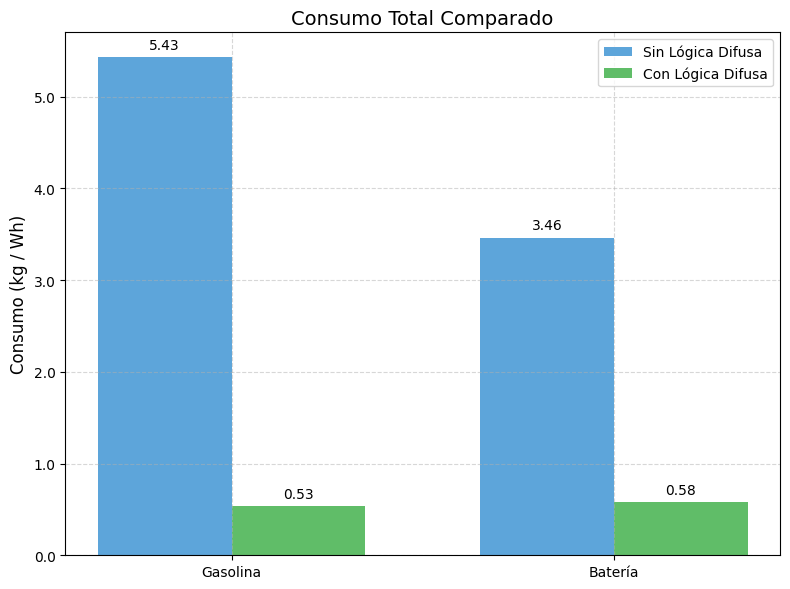

In [23]:
import matplotlib.ticker as mtick

# === Ejecutar simulaciones ===
VelAct_difusa, consumo_comb_difusa, consumo_bat_difusa = simular_con_difusa()
VelAct_sin_difusa, consumo_comb_sin_difusa, consumo_bat_sin_difusa = simular_sin_difusa()

# === Cálculo de errores ===
error_difusa = VelSET - VelAct_difusa
error_sin_difusa = VelSET - VelAct_sin_difusa
rmse_difusa = np.sqrt(np.mean(error_difusa**2))
rmse_sin_difusa = np.sqrt(np.mean(error_sin_difusa**2))

# === 1. Velocidad sin lógica difusa vs objetivo ===
plt.figure(figsize=(12, 5))
plt.plot(VelSET, '--', label='Velocidad Objetivo', linewidth=2)
plt.plot(VelAct_sin_difusa, label='Sin Lógica Difusa', linewidth=2)
plt.title('Velocidad Objetivo vs Sin Lógica Difusa', fontsize=14)
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [m/s]')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === 2. Velocidad con lógica difusa vs objetivo ===
plt.figure(figsize=(12, 5))
plt.plot(VelSET, '--', label='Velocidad Objetivo', linewidth=2)
plt.plot(VelAct_difusa, label='Con Lógica Difusa', linewidth=2)
plt.title('Velocidad Objetivo vs Con Lógica Difusa', fontsize=14)
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [m/s]')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === 3. Error absoluto ===
plt.figure(figsize=(12, 4))
plt.plot(np.abs(error_sin_difusa), label='Error Sin Difusa', linestyle='--')
plt.plot(np.abs(error_difusa), label='Error Con Difusa', linestyle='-')
plt.title(f'Error Absoluto | RMSE Sin Difusa: {rmse_sin_difusa:.2f}, Con Difusa: {rmse_difusa:.2f}', fontsize=13)
plt.xlabel('Tiempo [s]')
plt.ylabel('Error Absoluto [m/s]')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === 4. Comparación de consumo total ===
labels = ['Gasolina', 'Batería']
consumo_sin = [consumo_comb_sin_difusa, consumo_bat_sin_difusa]
consumo_con = [consumo_comb_difusa, consumo_bat_difusa]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(x - width/2, consumo_sin, width, label='Sin Lógica Difusa', color='#5DA5DA')
bar2 = ax.bar(x + width/2, consumo_con, width, label='Con Lógica Difusa', color='#60BD68')

ax.set_ylabel('Consumo (kg / Wh)', fontsize=12)
ax.set_title('Consumo Total Comparado', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Anotar valores en barras
for rect in bar1 + bar2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 4),
                textcoords="offset points",
                ha='center', va='bottom')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
